<a href="https://colab.research.google.com/github/mdfirozwadud/alzheimers-detection-cnn/blob/main/Milesstone_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [54]:
import os
import shutil
import random
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
from google.colab import files

import tensorflow as tf
from tensorflow import keras


print("All libraries imported successfully!")

All libraries imported successfully!


#**Download Dataset**
We are using the Dataset from the kaggle.
Here is the link: https://www.kaggle.com/datasets/marcopinamonti/alzheimer-mri-4-classes-dataset


In [55]:
!pip install kaggle

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json


In [56]:
!kaggle datasets download -d marcopinamonti/alzheimer-mri-4-classes-dataset

!unzip alzheimer-mri-4-classes-dataset.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (46).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (47).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (48).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (49).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (5).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (50).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (51).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (52).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (53).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (54).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemen

In [58]:
source_dir = '/content/dataset/Alzheimer_MRI_4_classes_dataset'
output_dir = '/content/split_dataset'

for cls in os.listdir(source_dir):
    cls_path = os.path.join(source_dir, cls)
    if not os.path.isdir(cls_path):
        continue

    images = os.listdir(cls_path)
    train, temp = train_test_split(images, test_size=0.3, random_state=42)
    val, test = train_test_split(temp, test_size=0.33, random_state=42)

    for split, imgs in [('train', train), ('val', val), ('test', test)]:
        dest = os.path.join(output_dir, split, cls)
        os.makedirs(dest, exist_ok=True)
        for img in imgs:
            shutil.copy(os.path.join(cls_path, img), os.path.join(dest, img))

print("Dataset split complete (70% train, 20% val, 10% test)")

Dataset split complete (70% train, 20% val, 10% test)


# **Data Visualization Before Preprocessing**

In [59]:
train_dir = f'{output_dir}/train'
classes = sorted(os.listdir(train_dir))
counts = {s: {c: len(os.listdir(f'{output_dir}/{s}/{c}')) for c in classes}
          for s in ['train', 'val', 'test']}

### **Original Dataset: Image Distribution Across Train/Val/Test Splits**

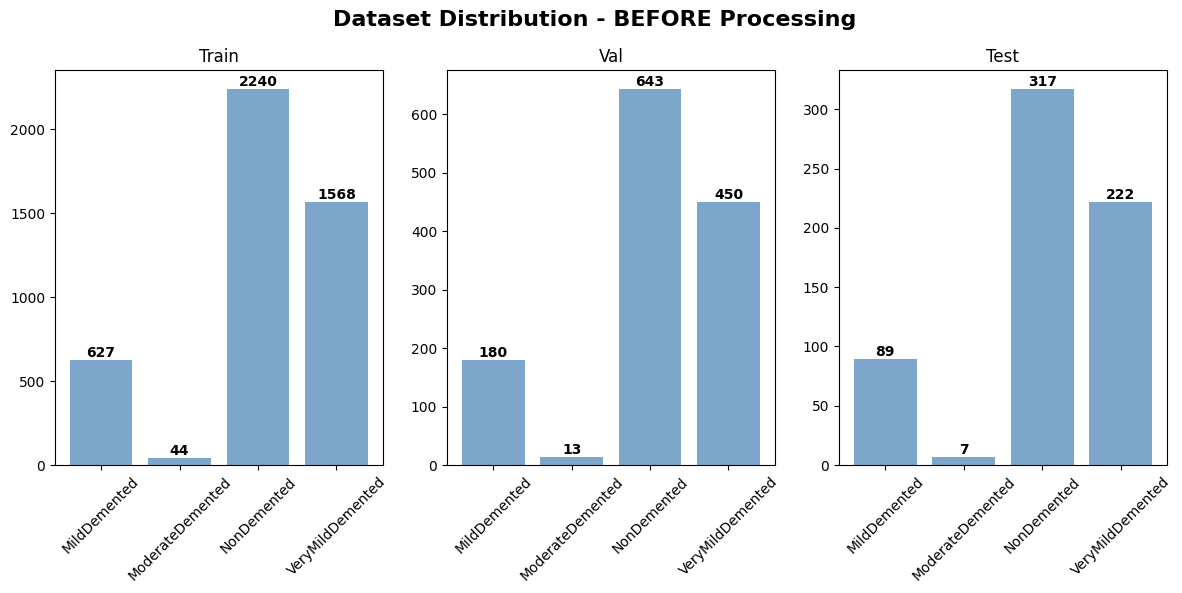

In [62]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
fig.suptitle('Dataset Distribution - BEFORE Processing', fontsize=16, fontweight='bold')
for ax, (split, data) in zip(axes, counts.items()):
    bars = ax.bar(data.keys(), data.values(), color='steelblue', alpha=0.7)
    ax.set_title(split.capitalize(), fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h, int(h), ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

### **Visual Inspection: Random Samples from Each Class (Original Images)**

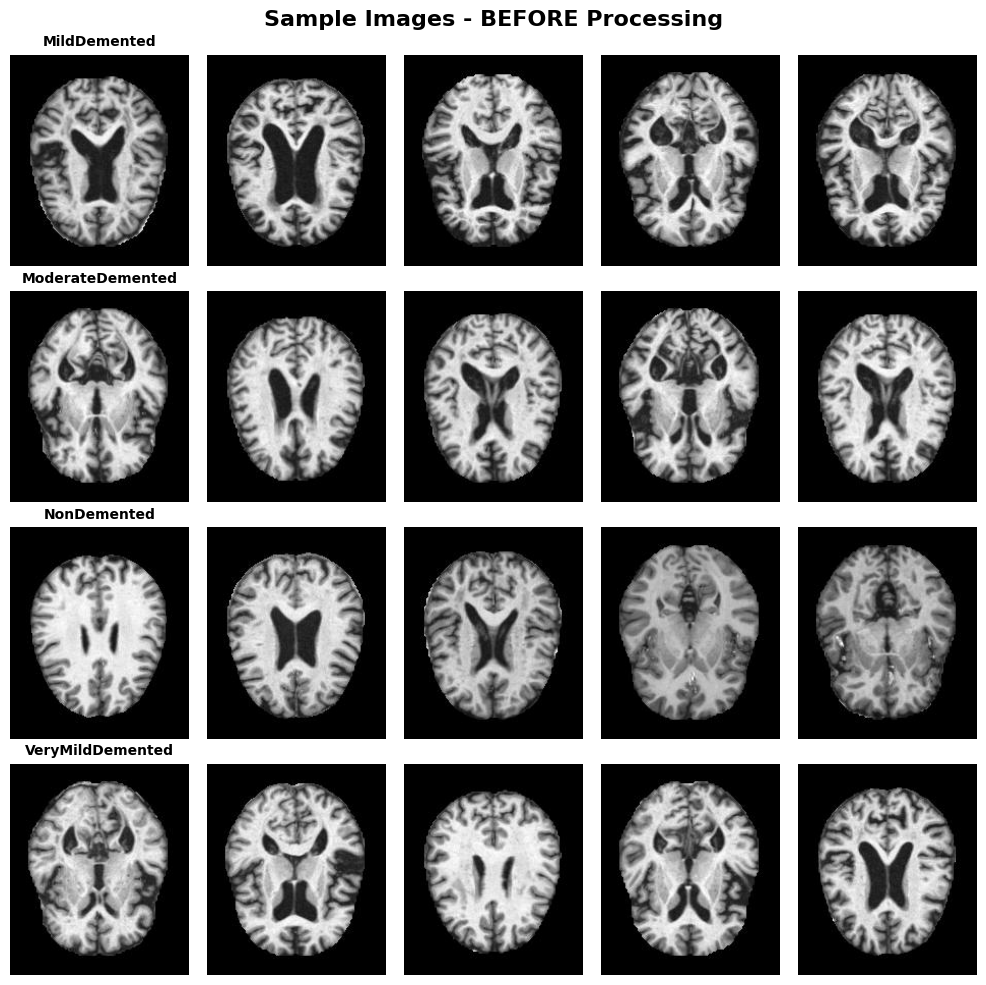

In [68]:
fig, axes = plt.subplots(len(classes), 5, figsize=(10, 10))
fig.suptitle('Sample Images - BEFORE Processing', fontsize=16, fontweight='bold')
for i, cls in enumerate(classes):
    imgs = random.sample(os.listdir(f'{train_dir}/{cls}'), min(5, len(os.listdir(f'{train_dir}/{cls}'))))
    for j, img in enumerate(imgs):
        axes[i, j].imshow(Image.open(f'{train_dir}/{cls}/{img}'), cmap='gray')
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(cls, fontweight='bold', fontsize=10)
plt.tight_layout()
plt.show()

### **Class Balance Analysis: Distribution Across Splits (Before Processing)**

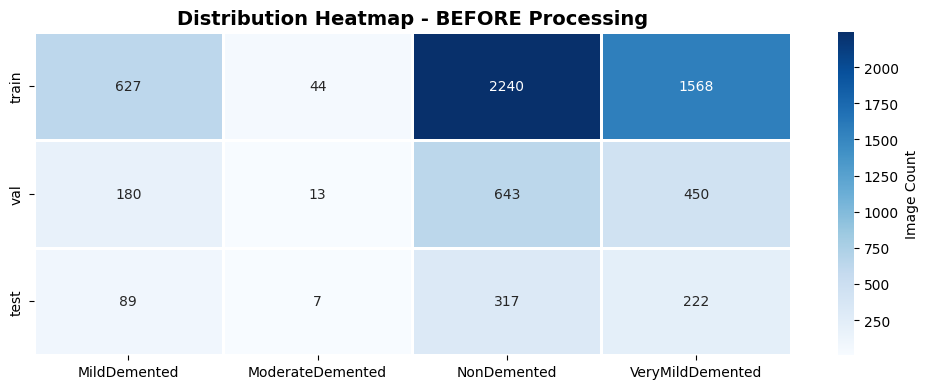

In [69]:
df = pd.DataFrame(counts).T
plt.figure(figsize=(10, 4))
sns.heatmap(df, annot=True, fmt='d', cmap='Blues', linewidths=1, cbar_kws={'label': 'Image Count'})
plt.title('Distribution Heatmap - BEFORE Processing', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### **Dataset Summary Statistics**

In [70]:
print(f"Summary:")
print(f"Total: {df.sum().sum()} images")
print(f"Train: {df.loc['train'].sum()} | Val: {df.loc['val'].sum()} | Test: {df.loc['test'].sum()}")
print(f"Classes: {', '.join(classes)}")

Summary:
Total: 6400 images
Train: 4479 | Val: 1286 | Test: 635
Classes: MildDemented, ModerateDemented, NonDemented, VeryMildDemented


#**Download Split Dataset**

In [10]:
# zip_path = '/content/split_dataset.zip'
# with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
#     for root, _, files_list in os.walk(output_dir):
#         for file in files_list:
#             file_path = os.path.join(root, file)
#             zipf.write(file_path, os.path.relpath(file_path, output_dir))

# print(f"Zip created: {os.path.getsize(zip_path) / (1024*1024):.2f} MB")
# files.download(zip_path)
# print("Download started!")

Zip created: 33.58 MB


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download started!


# **Preparing For Training**

In [71]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    zoom_range=0.15
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/split_dataset/train',
    target_size=(176, 176),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    '/content/split_dataset/val',
    target_size=(176, 176),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    '/content/split_dataset/test',
    target_size=(176, 176),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print("Data loaded with augmentation!")

Found 4479 images belonging to 4 classes.
Found 1286 images belonging to 4 classes.
Found 635 images belonging to 4 classes.
Data loaded with augmentation!


### **Download the Preprocessed Data**

In [51]:
zip_path = '/content/preprocessed_dataset.zip'
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files_list in os.walk(processed_dir):
        for file in files_list:
            file_path = os.path.join(root, file)
            zipf.write(file_path, os.path.relpath(file_path, processed_dir))

print(f"Preprocessed data zipped: {os.path.getsize(zip_path) / (1024*1024):.2f} MB")
files.download(zip_path)
print("Download started!")

✓ Preprocessed data zipped: 31.11 MB


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Download started!


# **Training and Evaluation**

In [36]:
model = keras.models.Sequential([keras.layers.Flatten(input_shape = [176,176,3]),
keras.layers.Dense(100, activation = 'relu' ),
keras.layers.Dense(200, activation = 'relu' ),

keras.layers.Dense(200, activation = 'relu' ),

keras.layers.Dense(200, activation = 'relu' ),

keras.layers.Dense(200, activation = 'relu' ),
keras.layers.Dense(4, activation = 'softmax')])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [37]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=10,
                                            restore_best_weights=True)

In [38]:
model.compile(optimizer='adam',
loss=tf.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc')])

In [39]:
result = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[callback]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 37s 250ms/step - auc: 0.7189 - loss: 1.8900 - val_auc: 0.8048 - val_loss: 1.0420
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 229ms/step - auc: 0.7827 - loss: 1.0392 - val_auc: 0.8141 - val_loss: 1.0357
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 33s 234ms/step - auc: 0.7932 - loss: 1.0336 - val_auc: 0.7971 - val_loss: 1.0465
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 33s 234ms/step - auc: 0.7975 - loss: 1.0133 - val_auc: 0.8151 - val_loss: 1.0240
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 228ms/step - auc: 0.7981 - loss: 1.0108 - val_auc: 0.7624 - val_loss: 1.0633
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 33s 233ms/step - auc: 0.7970 - loss: 1.0153 - val_auc: 0.8125 - val_loss: 1.0174
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 33s 233ms/step - auc: 0.7912 - loss: 1.0381 - val_auc: 0.8137 - val_loss: 1.0234
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - auc: 0.7991 - loss: 1.0178 - val_auc: 0.8079 - val_loss: 1.0679
Epoch 9/50
140/140 ━━━━━━━━━━━━━

In [40]:
loss, accuracy = model.evaluate(test_generator)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - auc: 0.7082 - loss: 1.2107
Loss:  0.9813950657844543
Accuracy:  0.8089284896850586


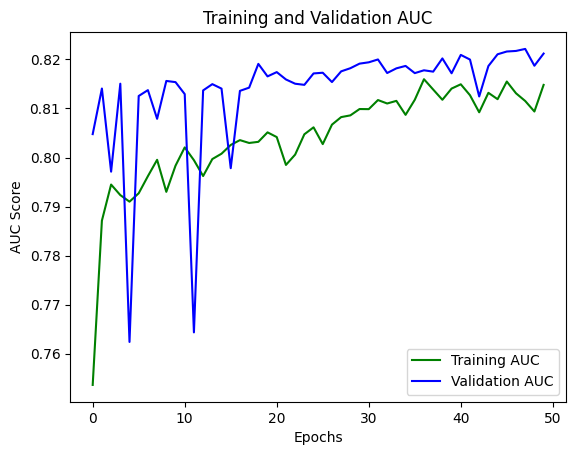

In [41]:
loss_train = result.history['auc']
loss_val = result.history['val_auc']
epochs = range(len(loss_train))
plt.plot(epochs, loss_train, 'g', label='Training AUC')
plt.plot(epochs, loss_val, 'b', label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC Score')
plt.legend()
plt.show()

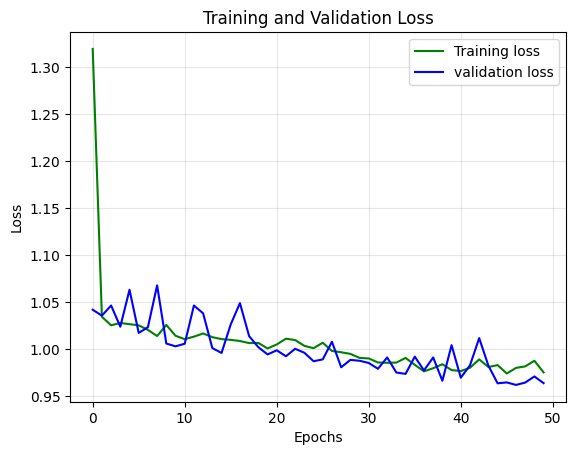

In [42]:
loss_train = result.history['loss']
loss_val = result.history['val_loss']
epochs = range(len(loss_train))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [43]:
model = keras.models.Sequential([
keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape = [176,176,3]),
keras.layers.MaxPooling2D(),
keras.layers.Conv2D(32, (2, 2), activation='relu'),
keras.layers.MaxPooling2D(),

keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),

keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),
keras.layers.Dropout(0.2),

keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),
keras.layers.Dropout(0.2),

keras.layers.Flatten(),

keras.layers.Dense(512, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.7),

keras.layers.Dense(128, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.5),

keras.layers.Dense(64, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.3),

keras.layers.Dense(4, activation ='softmax')])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [44]:
model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=[keras.metrics.AUC(name='auc')]
    )

In [45]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    verbose=1,
    callbacks=[callback]
)

Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 64s 340ms/step - auc: 0.5498 - loss: 1.8952 - val_auc: 0.7799 - val_loss: 1.1215
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 34s 242ms/step - auc: 0.6912 - loss: 1.3340 - val_auc: 0.5445 - val_loss: 1.3240
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 34s 241ms/step - auc: 0.7536 - loss: 1.1659 - val_auc: 0.6260 - val_loss: 1.3941
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 34s 240ms/step - auc: 0.7853 - loss: 1.0700 - val_auc: 0.6012 - val_loss: 1.5301
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 34s 246ms/step - auc: 0.8023 - loss: 1.0102 - val_auc: 0.8245 - val_loss: 0.9525
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 34s 239ms/step - auc: 0.8100 - loss: 0.9938 - val_auc: 0.6039 - val_loss: 1.5390
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 34s 241ms/step - auc: 0.8036 - loss: 1.0049 - val_auc: 0.8116 - val_loss: 1.0581
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 34s 244ms/step - auc: 0.7921 - loss: 1.0227 - val_auc: 0.8231 - val_loss: 0.9527
Epoch 9/50
140/140 ━━━━━━━━━━━━━

In [47]:
loss, accuracy = model.evaluate(test_generator)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - auc: 0.7840 - loss: 0.9852
Loss:  0.8817728161811829
Accuracy:  0.8457523584365845


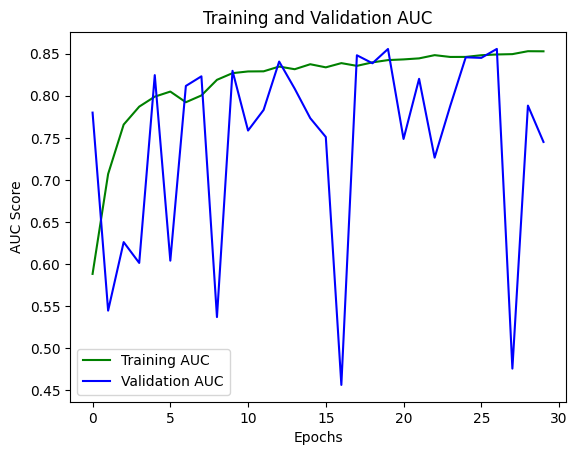

In [48]:
loss_train = history.history['auc']
loss_val = history.history['val_auc']
epochs = range(len(loss_train))
plt.plot(epochs, loss_train, 'g', label='Training AUC')
plt.plot(epochs, loss_val, 'b', label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC Score')
plt.legend()
plt.show()

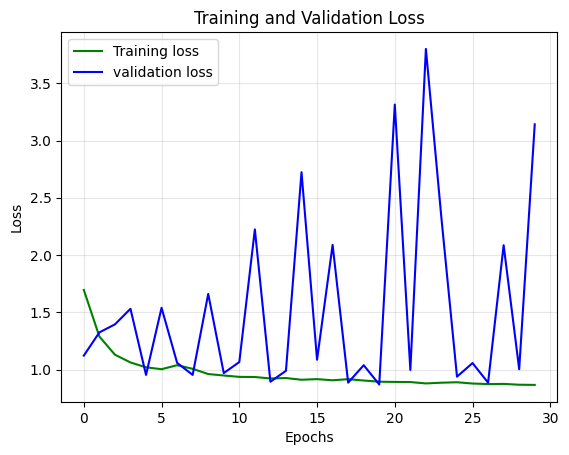

In [49]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(len(loss_train))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()